In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer


%matplotlib inline

In [2]:
df = pd.read_csv("../data/clean_data.csv")

df.head()

,userid,amount,usercurrencyamount,usercurrencycode,provider,countrycode,market,coins
0,049d2b63-a415-4a72-a9de-ce4ab621945d,2.53,2.01,chf,paypal,ch,gb,332
1,c14dfe23-2763-4ed4-8970-ef9da9d294ad,1.28,1.10,chf,paypal,ch,gb,7988
2,b6779fec-96f6-4386-a60c-70b64a3b40e6,2.60,2.34,eur,paypal,at,gb,538
3,ffb941d3-6ea6-4635-afe9-49d7af1349a9,3.83,5.66,aud,paypal,nz,au,1685
4,be50b2d4-4782-4258-a4fa-ecf38a100219,1.24,12.83,nok,paypal,no,gb,1516


In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2,random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25,random_state=1)

df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

y_train = df_train["amount"].values
y_val = df_val["amount"].values
y_test = df_test["amount"].values

del df_train["amount"]
del df_val["amount"]
del df_test["amount"]

cat = [  "provider", "countrycode", "market"]
num = ["usercurrencyamount", "coins"]   

In [6]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train[cat + num].to_dict(orient="records"))
X_val = dv.transform(df_val[cat + num].to_dict(orient="records"))

In [18]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)
print(f"Accuracy: {mean_squared_error(y_val,y_pred)}")
print(f"R^2: {r2_score(y_val,y_pred)}")

Accuracy: 8.814303884918436
R^2: 0.15343529487429897


In [19]:
from sklearn.linear_model import Ridge

alphas = [0, 0.01, 0.1, 1, 10]
solvers = ["svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]

scores = []
for s in solvers:
    for a in alphas:
        lr = Ridge(alpha=a, solver=s)
        lr.fit(X_train,y_train)
        y_pred = lr.predict(X_val)
        scores.append((s,a,mean_squared_error(y_val,y_pred),r2_score(y_val,y_pred)))
df_scores = pd.DataFrame(scores,columns=["solver","alpha","score","r2"])
df_scores.sort_values(by=["score","r2"], ascending=True).head(10)

d:\git_repo\ml_zoomcamp_midterm\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.85629e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\git_repo\ml_zoomcamp_midterm\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.85009e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\git_repo\ml_zoomcamp_midterm\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.79026e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\git_repo\ml_zoomcamp_midterm\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.32908e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


,solver,alpha,score,r2
3,svd,1.00,8.814192,0.153446
8,cholesky,1.00,8.814192,0.153446
2,svd,0.10,8.814288,0.153437
7,cholesky,0.10,8.814288,0.153437
1,svd,0.01,8.814302,0.153435
6,cholesky,0.01,8.814302,0.153435
0,svd,0.00,8.814304,0.153435
5,cholesky,0.00,8.814304,0.153435
4,svd,10.00,8.816059,0.153267
9,cholesky,10.00,8.816059,0.153267


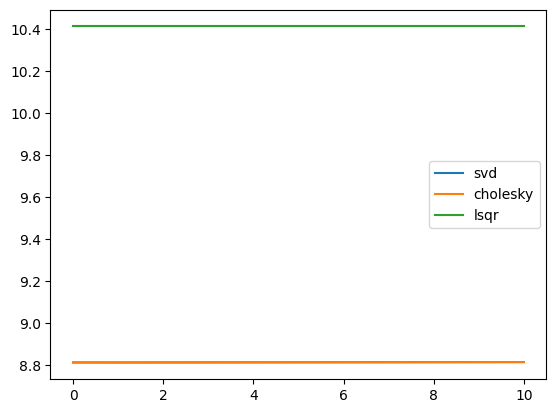

In [22]:
for s in solvers:
    if s in ["svd", "cholesky", "lsqr"]:
        plt.plot(df_scores[df_scores["solver"] == s]["alpha"],df_scores[df_scores["solver"] == s]["score"], label=s)

plt.legend()

# Best combo for Ridge seems solver="svd", alpha=1.0

In [26]:
from sklearn.tree import DecisionTreeRegressor

max_depths = [1, 2, 3, 4, 5, 6, 7, None]
min_sample_leafs = [1,2, 5, 10,20]

scores = []
for s in min_sample_leafs:
    for d in [1, 2, 3, 4, 5, 6, 7, None]:
        dt = DecisionTreeRegressor(max_depth=d, random_state=1, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        scores.append((d,s,mean_squared_error(y_val,y_pred),r2_score(y_val,y_pred)))
df_scores = pd.DataFrame(scores,columns=["max_depth","min_samples_leaf","score","r2"])
df_scores.sort_values(by=["score","r2"], ascending=True).head(10)

# Best combo for DecisionTreeRegressor seems max_depth=7, min_samples_leaf=1
# Leaving max_depth=None will cause overfitting

,max_depth,min_samples_leaf,score,r2
7,NaN,1,0.020151,0.998065
15,NaN,2,0.033286,0.996803
23,NaN,5,0.106647,0.989757
31,NaN,10,0.307538,0.970463
6,7.0,1,0.339468,0.967396
39,NaN,20,0.410237,0.960599
14,7.0,2,0.411864,0.960443
22,7.0,5,0.418417,0.959813
30,7.0,10,0.490815,0.952860
5,6.0,1,0.505574,0.951442


In [28]:
from sklearn.ensemble import RandomForestRegressor

scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append((n, mean_squared_error(y_val, y_pred), r2_score(y_val, y_pred)))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score', 'r2'])
df_scores.sort_values(by=["score","r2"], ascending=True).head(10)

,n_estimators,score,r2
17,180,0.025647,0.997537
13,140,0.025667,0.997535
10,110,0.025733,0.997528
16,170,0.025933,0.997509
18,190,0.025940,0.997509
12,130,0.025951,0.997508
14,150,0.026244,0.997479
11,120,0.026675,0.997438
19,200,0.026775,0.997428
15,160,0.026872,0.997419


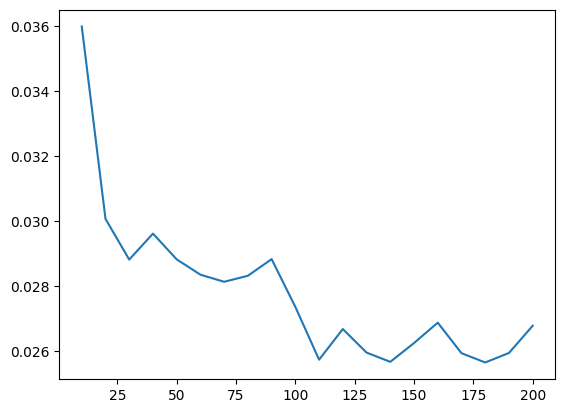

In [29]:
plt.plot(df_scores["n_estimators"],df_scores["score"])

# Best performance starts around n_estimators=110

In [32]:
scores = []
max_depths = [1, 2, 3, 4, 5, 6, 7, None]
n_estimators = list(range(100,180,10))

for d in max_depths:
    for n in n_estimators:
        rf = RandomForestRegressor(n_estimators=n,max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        scores.append((n, d, mean_squared_error(y_val, y_pred), r2_score(y_val, y_pred)))
df_scores = pd.DataFrame(scores, columns=['n_estimators','max_depth', 'score', 'r2'])
df_scores.sort_values(by=["score","r2"], ascending=True).head(10)

,n_estimators,max_depth,score,r2
60,140,NaN,0.025667,0.997535
57,110,NaN,0.025733,0.997528
63,170,NaN,0.025933,0.997509
59,130,NaN,0.025951,0.997508
61,150,NaN,0.026244,0.997479
58,120,NaN,0.026675,0.997438
62,160,NaN,0.026872,0.997419
56,100,NaN,0.027356,0.997373
49,110,7.0,0.210921,0.979742
50,120,7.0,0.212604,0.979581


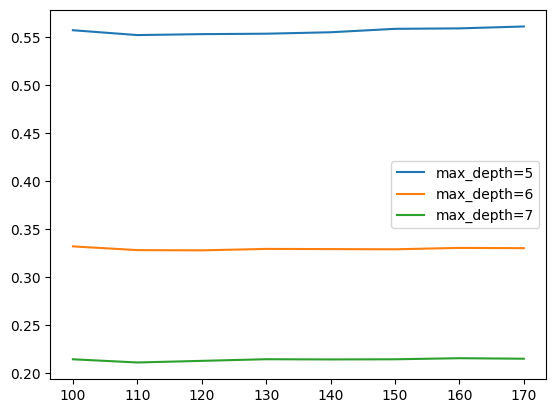

In [34]:
for d in [5,6,7]:
    plt.plot(df_scores[df_scores["max_depth"]==d]["n_estimators"],df_scores[df_scores["max_depth"]==d]["score"], label=f"max_depth={d}")

plt.legend()

# Best performance starts around n_estimators=110 with a max_depth=7

In [47]:
import xgboost as xgb

scores = {}

def parse_xgboost_output(s):
    lines = s.strip().split('\n')
    eval_data = []
    for line in lines:
        num_iter, train_score, val_score = line.split('\t')
        num_iter = int(num_iter.strip('[]'))
        train_score = float(train_score.split(':')[1])
        val_score = float(val_score.split(':')[1])
        eval_data.append((num_iter, train_score, val_score))

    df_eval = pd.DataFrame(eval_data, columns=['tree', 'train_score', 'val_score'])
    return df_eval

features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [40]:
%%capture output


xgb_params = {
    'eta': 1.0,
    'max_depth': 7,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
key = f'eta={str(xgb_params["eta"])}'
scores[key] = parse_xgboost_output(output.stdout)

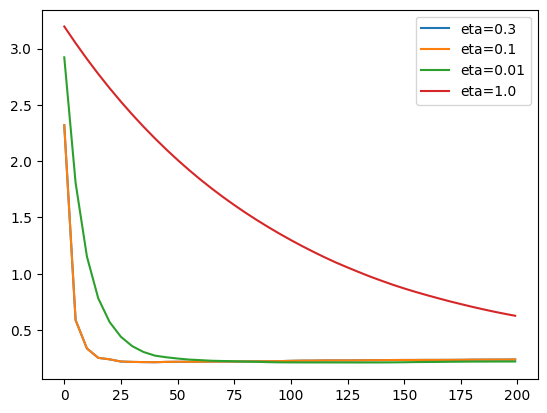

In [41]:
for k, df in scores.items():
    plt.plot(df.tree, df.val_score, label=k)
plt.legend()

In [45]:
%%capture output


xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
key = f'max_depth={str(xgb_params["max_depth"])}'
scores[key] = parse_xgboost_output(output.stdout)

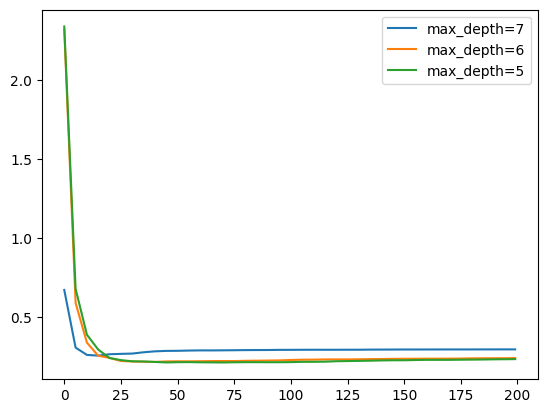

In [46]:
for k, df in scores.items():
    plt.plot(df.tree, df.val_score, label=k)
plt.legend()

In [50]:
%%capture output


xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 10,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
key = f'min_child_weight={str(xgb_params["min_child_weight"])}'
scores[key] = parse_xgboost_output(output.stdout)

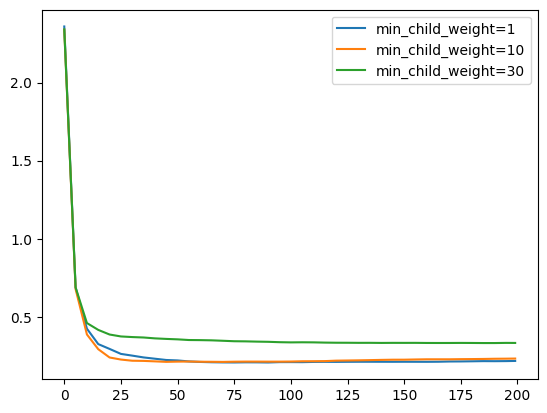

In [51]:
for k, df in scores.items():
    plt.plot(df.tree, df.val_score, label=k)
plt.legend()

Best models:

- RandomForestRegressor with *n_estimators=110* and *max_depth=7*
- XGBoost with following settings:
  
  ```python
  xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 10,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
  ```

In [52]:
df_full_train.reset_index(drop=True)

y_full_train = df_full_train["amount"].values

del df_full_train["amount"]


X_full_train = dv.fit_transform(df_full_train[cat + num].to_dict(orient="records"))
X_test = dv.transform(df_test[cat + num].to_dict(orient="records"))

In [53]:
rf = RandomForestRegressor(n_estimators=110, max_depth=7, random_state=1)
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict(X_test)

mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

(0.24353116890901794, 0.97723836456664)

In [54]:
features = dv.get_feature_names_out().tolist()
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 10,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dfulltrain, num_boost_round=200)
y_pred = model.predict(dtest)

mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

(0.11042932519640015, 0.9896787255096227)